In [1]:
import numpy as np
from scipy.misc import derivative
from scipy.optimize import minimize
from golden_section_search import GoldenSectionSearch
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import ticker
%matplotlib inline

In [2]:
def f(x1, x2):
    return np.float64((x1 - 2)**4 + (x1 - 2 * x2)**2)

# Методи змінної метрики (квазіньютонові методи). Метод ДФП.

В методах второго порядка при поиске минимума используют информацию о функции и её производных до второго порядка включительно.
К этой группе относят метод Ньютона и его модификации

In [20]:
class DFP:
    """
        davidon–fletcher–powell method
        The DFP class provides solution to 2d - optimization task without subjects.

        Attributes
        ----------
        func (function): Coefficients of function(x) that we try to optimize
        x0 (tuple): Starting 2D dot
        n_iter (int): Maximal amount of possible iterations
        eps (float): Precision of method's approach
        y (list[np.array(float)]): List of dots that are updating during the algo
        grad (list[np.array(float]): List of gradients in y dots
        p (list[np.array(float]): List of ANTI-gradients of grad
        H (list[np.array(float)]): List of positive defined matrices (hessians)
        alpha (list[np.array(float)]): List of coefs alpha that are solution of 1dim opt
        """
    def __init__(self, func, x0, n_iter=20, eps=1e-2):
        """
                The constructor for DFP class.

                Parameters:
                    func: Coefficients of function(x) that we try to optimize
                    x0: Starting 2D dot
                    n_iter: Maximal amount of possible iterations
                    eps: Precision of method's approach
                """
        self.func = func
        self.x0 = x0
        self.n_iter = n_iter
        self.eps = eps
        self.y = []
        self.grad = []
        self.p = []
        self.H = []
        self.alpha = []

    def partial_derivative(self, var=0, point=[]):
        """
                Function that returns partial derivative in some dot
            Parameters:
                :param var: number of variable that will be diff
                :param point: point
            :return: partial derivative in some dot
        """
        args = point[:]

        def wraps(x):
            args[var] = x
            return self.func(*args)

        return derivative(wraps, point[var], dx=1e-6)

    def gradient(self, *dot):
        """
                    Function that counts gradient of function in dot
                :param dot: some dote
            :return: gradient of function
        """
        return np.array([self.partial_derivative(0, point=[*dot]),
                         self.partial_derivative(1, point=[*dot])])

    def vector_norm(self, vec):
        """
                    Function that returns first norm of n-dim vector
                :param vec: vector
        :return: 1st vec norm
        """
        return np.sqrt(np.sum([coord ** 2 for coord in vec]))

    def opt(self, dot, gr):
        """
                    Function that solves 1-d optimization problem using GoldenSecantSearch method.
        :return: optimal value of alpha
        """
        #new_f = lambda t, opt='min': ((dot[0] + t * gr[0]) - 2) ** 4 + (
                    #(dot[0] + t * gr[0]) - 2 * (dot[1] - t * gr[1])) ** 2

        def temp(t=1, dota=dot, gra=gr):
            return self.func(dota[0] + t * gra[0], dota[1] + t * gra[1])

        new_f = lambda t, opt='min': temp(t, dot, gr)
        a = 0
        b = 1
        model = GoldenSectionSearch(a=a, b=b, func=new_f, opt='min')
        return model.find_opt()

    def get_hessian(self, delta_y, delta_grad, h):
        """
                        Function that updates value of positive defined matrix using
                        davidon–fletcher–powell method
                Parameters:
                :param delta_y: diff between neighbour dots
                :param delta_grad: diff between neighbour gradients
                :param h: positive defined matrix
        :return: updated matrix
        """
        delta_y = np.array([delta_y])
        delta_grad = np.array([delta_grad])

        tmp = np.divide(delta_y.T @ delta_y, delta_y @ delta_grad.T)

        tmp -= np.divide(h @ delta_grad.T @ delta_grad @ h,
                         delta_grad @ h @ delta_grad.T)

        return h + tmp

    def solve(self):
        it = 0
        self.H = [np.eye(2)]  # start hessian
        self.y = [np.array(self.x0)]  # array of all dots
        self.grad = []  # array of gradients
        self.p = []  # array of antigradients
        self.alpha = []  # array of optimal coef
        k = j = 1
        n = len(self.x0)
        opt_x = self.y[-1]

        self.grad.append(self.gradient(*self.y[-1]))

        while self.vector_norm(self.grad[-1]) > self.eps and it < self.n_iter:
            #  на первой итерации не считаем градиент так как он уже посчитан
            if it != 0:
                self.grad.append(self.gradient(*self.y[-1]))

            #  вычисляем антиградиент
            self.p.append(np.dot(-self.H[-1], self.grad[-1]))

            #  решаем одномерную задачу оптимизации для отыскания alpha
            self.alpha.append(self.opt(self.y[-1], self.p[-1]))

            #  обновление точки
            self.y.append(self.y[-1] + self.alpha[-1] * self.p[-1])

            if j < n:
                # считаем градиент в обновленной точке
                self.grad.append(self.gradient(*self.y[-1]))

                #  разность двух соседних точек
                t = self.alpha[-1] * self.p[-1]

                #  разность двух соседний градиентов
                q = self.grad[-1] - self.grad[-2]

                #  обновляем положительно определенную матрицу по методу Давидона-Флетчера-Пауела
                self.H.append(self.get_hessian(t, q, self.H[-1]))

                j = j + 1
            elif j == n:
                #  пологаем последнюю точку оптимальнойй
                opt_x = self.y[-1]
                k = k + 1
                j = 1
                #  обновляем матрицу, делаем ее единичной
                self.H.append(np.eye(2))
            it += 1
        self.n_iter = it
        return opt_x

    def stats(self):
        adder = {'k': '', 'xk': '', 'f(xk)': '',
                 'grad f(xk)': '', 'p(xk)': '',
                 '|grad f(xk)|': '', 'alpha k': ''}

        cols = list(adder.keys())
        df = pd.DataFrame(columns=cols)
        for k in range(self.n_iter):

            adder['k'] = k
            adder['xk'] = self.y[k]
            adder['f(xk)'] = self.func(*self.y[k])
            adder['grad f(xk)'] = self.grad[k]
            try :
                adder['p(xk)'] = self.p[k]
            except IndexError:
                adder['p(xk)'] = np.nan
            adder['|grad f(xk)|'] = self.vector_norm(self.grad[k])
            adder['alpha k'] = self.alpha[k]

            df = df.append(adder, ignore_index=True)
        return df

    def plot_contour_line(self):
        x1 = np.linspace(-5, 5)
        x2 = np.linspace(-5, 5)
        x1, x2 = np.meshgrid(x1, x2)
        f0 = (x1 - 2) ** 4 + (x1 - 2 * x2) ** 2

        fig, ax = plt.subplots(figsize=(12, 8))
        locator = ticker.SymmetricalLogLocator(linthresh=0.1, base=2)

        picture = ax.contourf(x1, x2, f0, locator=locator)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        plt.show()

    def plot_approach(self):
        x1 = np.linspace(-2, 4)
        x2 = np.linspace(-2, 4)
        x1, x2 = np.meshgrid(x1, x2)
        f0 = (x1 - 2) ** 4 + (x1 - 2 * x2) ** 2
        xs = np.array(self.y)

        fig, ax = plt.subplots(figsize=(12, 8))
        locator = ticker.SymmetricalLogLocator(linthresh=0.1, base=2)

        ax.plot(xs[:, 0], xs[:, 1], color='black', linewidth=4)
        picture = ax.contourf(x1, x2, f0, locator=locator)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        plt.show()

    def notebook_geom_process(self):
        fig = plt.figure(figsize=(20,15))
        ax = fig.add_subplot(1, 1, 1)

        x1 = np.linspace(-2, 4)
        x2 = np.linspace(-2, 4)
        x1, x2 = np.meshgrid(x1, x2)
        f0 = (x1 - 2)**4 + (x1 - 2*x2)**2
        xs = np.array(self.y)

        locator = ticker.SymmetricalLogLocator(linthresh=0.1, base=2)

        picture = ax.contourf(x1, x2, f0, locator=locator)
        ax.scatter(xs[-1,0], xs[-1,1], color='red')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        display(fig)

        clear_output(wait = True)
        plt.pause(0.5)

        for i in range(1, dfp.n_iter):

            ax.set_title('Iter: {}'.format(i),fontsize = 25)
            ax.plot(xs[i-1:i+1,0],xs[i-1:i+1,1], color='black', linewidth=4)
            display(fig)


            clear_output(wait = True)
            plt.pause(0.3)

In [21]:
dfp = DFP(f, (0.00, 3.00))
x_opt = dfp.solve()
df = dfp.stats()
df

,k,xk,f(xk),grad f(xk),p(xk),|grad f(xk)|,alpha k
0,0,"[0.0, 3.0]",52.000000,"[-43.9999999990448, 24.00000000335467]","[43.9999999990448, -24.00000000335467]",50.119856,0.045084
1,1,"[1.9836956181791439, 1.91798420809119]",3.430915,"[-3.704562932860256, 7.409091191457051]","[-1.7600106850194646, -5.200792777678936]",8.283624,0.190980
2,2,"[1.6475687775541266, 0.9247368034100668]",0.056193,"[-3.704562932860256, 7.409091191457051]","[0.5789084385025844, -0.8076193170891699]",8.283624,0.100809
3,3,"[1.7059282190001543, 0.8433211440214088]",0.007850,"[-0.5789084385025844, 0.8076193170891699]","[0.07921575301406858, 0.049110681996943115]",0.993672,0.954907
4,4,"[1.781571861645899, 0.8902172566974547]",0.002278,"[-0.06315134581068305, -0.07714372383168383]","[0.039410873494587564, 0.004549393004026417]",0.099696,0.572945
5,5,"[1.8041521074774391, 0.8928238067001921]",0.001814,"[-0.06315134581068305, -0.07714372383168383]","[0.030295877690830992, 0.019708497320091615]",0.099696,0.954907
6,6,"[1.8330818399926045, 0.9116435801876809]",0.000872,"[-0.039410873494587564, -0.004549393004026417]","[-0.0009868830401862407, 0.039178718470108016]",0.039673,0.135251
7,7,"[1.8329483634272934, 0.9169425270352173]",0.000780,"[0.006960910079573633, -0.07401797631029998]","[0.014915267660161593, 0.006946824069230875]",0.074345,0.954907
8,8,"[1.8471910504424698, 0.9235760949484382]",0.000545,"[0.006960910079573633, -0.07401797631029998]","[0.014194986297131566, 0.00015544218234624096]",0.074345,0.482772
9,9,"[1.8540439953919352, 0.9236511381148172]",0.000499,"[0.0009868830401862407, -0.039178718470108016]","[0.010450780874614282, 0.006132727104500904]",0.039191,0.954907


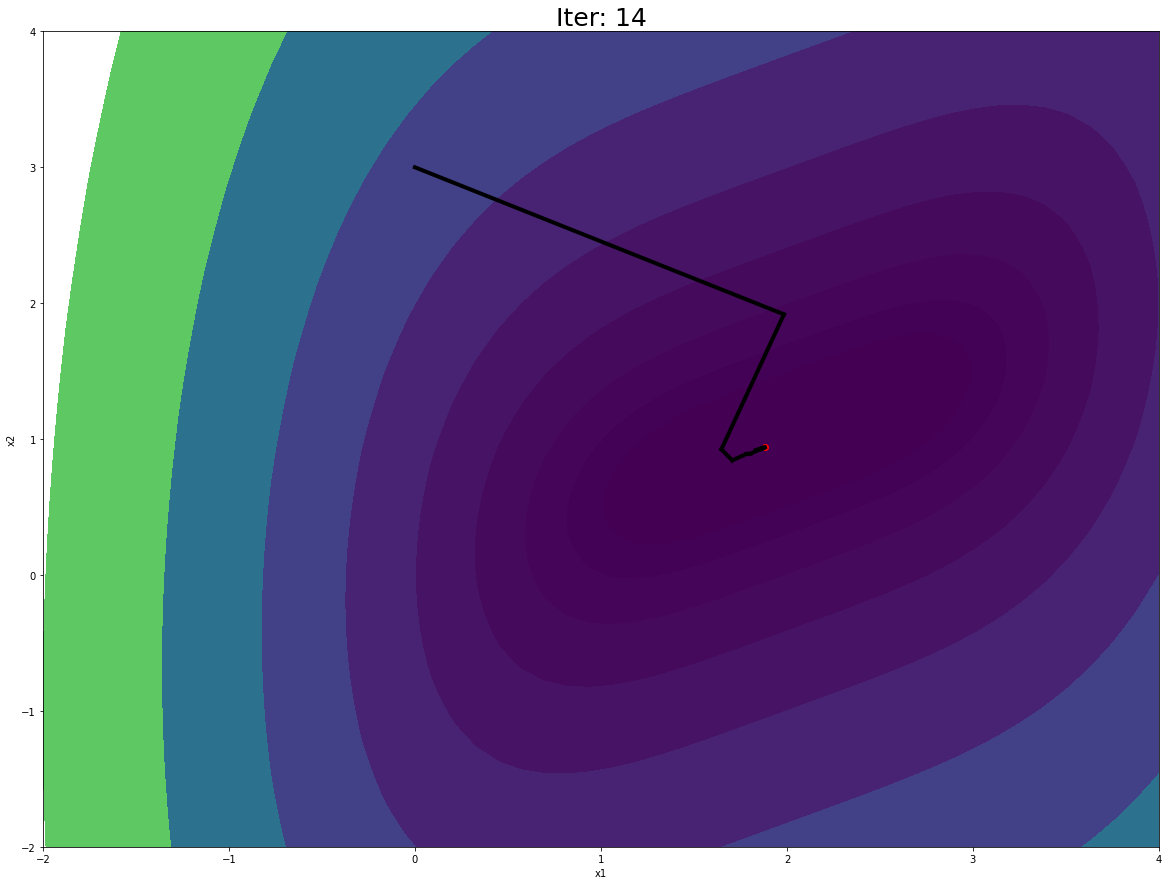

In [22]:
dfp.notebook_geom_process()

In [23]:
x_opt

array([1.88164031, 0.9392213 ])

In [24]:
f(*x_opt)

0.00020647782931004484